In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update({
    # ── Canvas size & resolution ───────────────────────────────────────────
    # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
    "figure.figsize": (12, 8),
    "figure.dpi": 200,       # crisp in-notebook / retina preview
    "savefig.dpi": 400,      # print-quality PNG/PDF

    # ── Fonts ──────────────────────────────────────────────────────────────
    "font.family": "sans-serif",
    "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
    "axes.titlesize": 24,
    # "axes.titleweight": "bold",
    "axes.labelsize": 24,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 20,

    # ── Axis & spine aesthetics ────────────────────────────────────────────
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.linewidth": 1,
    "axes.grid": True,
    "grid.color": "#E6E6E6",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.8,

    # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
    "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),

    # ── Figure background ─────────────────────────────────────────────────
    "figure.facecolor": "white",
})

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",           # slightly larger fonts for presentations / papers
    style="whitegrid",        # grid only on y-axis (good for histograms)
    palette="Set2",           # matches the rcParams colour cycle
)

# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent = True, **savefig_kwargs)

# 4.  Colour constants for this project (optional convenience)
COL_RAW      = sns.color_palette("Set2")[0]  # e.g. unweighted sample
COL_WEIGHTED = sns.color_palette("Set2")[1]  # weighted sample
COL_REF      = "0.35"                        # census reference (neutral grey)


In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/groot/Projects/neuroaging/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/groot/Projects/neuroaging/figures/fig3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" /"atlases" / ATLAS / "parcels.csv", index_col = 0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [4]:
metrics = ["gm_vol"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})



# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_1200596/2153488554.py:9: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv",index_col=0).reset_index(drop=True)


In [5]:
metric_cols = {metric: "volume" if metric == "gm_vol" else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df


In [6]:
israel_population = pd.read_csv(DATA_DIR / "processed" / "israel_population.csv")

In [7]:
# assign weights
for metric in metrics:
    data[metric]["subject_code"] = data[metric]["subject_code"].astype(str).str.zfill(4)

In [8]:
df = data[metrics[0]].drop_duplicates(subset=["subject_code"],keep="first").copy()

In [9]:
import pandas as pd

def group_by_age(df, age_col:str = "age_at_scan",n_bins:int=50):
    """
    Group participants by age into n_bins with equal number of participants.
    
    Parameters:
    - df: DataFrame containing the data
    - age_col: Column name for age
    - n_bins: Number of bins to create
    
    Returns:
    - DataFrame with an additional column for age groups
    """
    # Create age groups with equal number of participants
    df["age_group"] = pd.qcut(df[age_col], q=n_bins, labels=False)

    # Optional: Assign labels like "Q1", "Q2", etc.
    df["age_group_label"] = pd.qcut(
        df[age_col], q=n_bins, labels=[f"Q{i+1}" for i in range(n_bins)]
    )
    # Group by the age_group_label column
    group_stats = df.groupby("age_group_label")["age_at_scan"].agg(
        median_age="median", mean_age="mean", sd_age="std", n_participants="count"
    )

    # Merge stats back into original df
    return df.merge(group_stats, on="age_group_label", how="left")
    



In [ ]:
scns = {}
for metric in metrics:
    long_df = data[metric].copy()
    ages = group_by_age(long_df.drop_duplicates(subset="subject_code", keep="first"), age_col="age_at_scan", n_bins=50)
    age_group_map = ages[["subject_code", 'age_group_label']]
    if metric == "gm_vol":
        long_df["value"] = long_df["value"] / long_df["tiv"]
    # correct for sex
    wide_df = long_df.pivot_table(index="subject_code", columns=[region_col], values="value")
    # Step 2: Add age group info to wide matrix
    for group_name, group_df in ages.groupby("age_group_label"):
        # Create a new column for each age group
        region_matrix = wide_df.loc[group_df["subject_code"]]
        corr_matrix = region_matrix.corr(method="pearson")
        scns[group_name] = {"corr_matrix": corr_matrix, "metadata": group_df}
        # break
    # wide_df = wide_df.merge(age_group_map, left_on="subject_code", right_on="subject_code")
    # wide_df = wide_df.merge(age_group_map, left_on="subject_code", right_on="subject_code")
    # break

/tmp/ipykernel_1200596/2905021287.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group"] = pd.qcut(df[age_col], q=n_bins, labels=False)
/tmp/ipykernel_1200596/2905021287.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age_group_label"] = pd.qcut(
/tmp/ipykernel_1200596/2905021287.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

In [48]:
import bct
from tqdm import tqdm
network_matrices_dict = {}


def degree(mat, edge_threshold="auto"):
    """Calculate the degree of each node in the network."""
    G = mat.copy()
    # Threshold the matrix to remove weak connections
    if edge_threshold == "auto":
        edge_threshold = np.mean(mat)  # Use the mean as a threshold
    G[mat < edge_threshold] = 0  # Set weak connections to zero
    return bct.degrees_und(G)

network_measures = {
    "degree": degree,
    "strength": bct.strengths_und,
    "clustering": bct.clustering_coef_wu,
    "betweenness": bct.betweenness_wei,
    "global_efficiency": bct.efficiency_wei,
}


for group_name, group_data in tqdm(scns.items(), desc="Calculating network matrices"):
    mat = group_data["corr_matrix"].values.copy()
    metadata = group_data["metadata"].copy()
    np.fill_diagonal(mat, 0)  # Set diagonal to zero
    # Calculate the network matrices
    p = parcels.copy()
    for col, func in network_measures.items():
        p[col] = func(mat)
    p["group"] = group_name
    # Add metadata
    for col in ["median_age","mean_age", "sd_age", "n_participants"]:
        if col in metadata.columns:
            p[col] = metadata[col].values[0]
        else:
            p[col] = np.nan
    network_matrices_dict[group_name] = p
    # break

network_matrices = pd.concat(network_matrices_dict.values(), ignore_index=True)

Calculating network matrices: 100%|██████████| 50/50 [59:28<00:00, 71.36s/it] 


In [84]:
# do ols
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests


stats = {key: parcels.copy() for key in ["strength", "degree", "betweenness", "clustering"]}
for key, s in stats.items():
    # correlate between each metric and age
    for i, row in parcels.iterrows():
        # Prepare the data for OLS regression
        X_full = network_matrices.loc[network_matrices[region_col] == row[region_col]]
        y = X_full[key]
        age_vec = X_full["median_age"].astype(float)
        X = sm.add_constant(age_vec)
        # Fit the OLS model
        lin_model = sm.OLS(y, X).fit()
        quad_model = sm.OLS(y, sm.add_constant(np.column_stack((age_vec, age_vec**2)))).fit()
        # Store the results
        s.loc[i, "beta1"] = lin_model.params[1]
        s.loc[i, "intercept"] = lin_model.params[0]
        s.loc[i, "pval"] = lin_model.f_pvalue
        s.loc[i, "adj_r2"] = lin_model.rsquared_adj
        s.loc[i, "quad_beta2"] = quad_model.params[2]
        s.loc[i, "quad_beta1"] = quad_model.params[1]
        s.loc[i, "quad_intercept"] = quad_model.params[0]
        s.loc[i, "quad_pval"] = quad_model.f_pvalue
        s.loc[i, "quad_adj_r2"] = quad_model.rsquared_adj
        # compare the models
        f, p, _ = quad_model.compare_f_test(lin_model)
        s.loc[i, "f_statistic"] = f
        s.loc[i, "pval_quad_vs_linear"] = p
        # break
    s["pval_adj"] = multipletests(s["pval"], method="fdr_bh")[1]
    s["quad_pval_adj"] = multipletests(s["quad_pval"], method="fdr_bh")[1]
    s["pval_quad_vs_linear_adj"] = multipletests(s["pval_quad_vs_linear"], method="fdr_bh")[1]
    # break

/tmp/ipykernel_1200596/3668195824.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "beta1"] = lin_model.params[1]
/tmp/ipykernel_1200596/3668195824.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "intercept"] = lin_model.params[0]
/tmp/ipykernel_1200596/3668195824.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s.loc[i, "quad_beta2"] = quad_model.params[2]
/tmp/ipykernel_1200596/3668195824.py:24: Futu

In [85]:
import numpy as np
import pandas as pd
import nibabel as nb
from nilearn import surface, datasets
from surfplot import Plot
from matplotlib.colors import TwoSlopeNorm  # nice diverging colours
from neuromaps.datasets import fetch_fslr
from brainspace.datasets import load_parcellation


atlas_img = nib.load(nifti_matlab)

# ---------------------------------------------------------------------
# 2.  FETCH A STANDARD SURFACE  (fsaverage5 = 10k vertices per hemi)
# ---------------------------------------------------------------------
surfaces = fetch_fslr()
lh, rh = surfaces["veryinflated"]


# ---------------------------------------------------------------------
# 3.  SAMPLE ATLAS VOXELS → SURFACE  (nearest-neighbour so labels stay int)
# ---------------------------------------------------------------------
# add schaefer parcellation (no color bar needed)
lh_parc, rh_parc = load_parcellation("schaefer")

In [107]:
# ---------------------------------------------------------------------
# 4.  MAP REGION IDs → METRIC VALUES
#     vertices with label 0 (background) → NaN so they render transparent
# ---------------------------------------------------------------------
p_threshold = 0.05
value_threshold = 0

value_map = {}
value_map_subcortex = {"region": [], "value": [], "Hemisphere": []}

key = "strength"  # or "betweenness", "clustering"

vis_df = stats[key].copy()
p_column = "quad_pval"
value_column = "quad_adj_r2"

for i, row in vis_df.iterrows():
    label = row[region_col]
    if (row[p_column] < p_threshold) and (np.abs(row[value_column]) > value_threshold):
        value = row[value_column]
    else:
        value = np.nan
    if "schaefer" in ATLAS:
        if label > int(ATLAS.split("_")[1]):
            value_map_subcortex["region"].append(label)
            value_map_subcortex["value"].append(value)
            value_map_subcortex["Hemisphere"].append(row["hemisphere"])
        else:
            value_map[label] = value

vec = np.vectorize(lambda x: value_map.get(x, np.nan))
data_lh = vec(lh_parc)
data_rh = vec(rh_parc)

In [108]:
vis_df.sort_values("pval").head(20)

index                            name                     base_name  \
421    422                         mAMY-rh                          mAMY   
448    449                         mAMY-lh                          mAMY   
427    428                  HIP-head-m1-lh                   HIP-head-m1   
4        5              7Networks_LH_Vis_5              7networks_lh_vis   
400    401                  HIP-head-m1-rh                   HIP-head-m1   
447    448                         lAMY-lh                          lAMY   
420    421                         lAMY-rh                          lAMY   
139    140        7Networks_LH_Cont_PFCl_6        7networks_lh_cont_pfcl   
228    229             7Networks_RH_Vis_29              7networks_rh_vis   
150    151     7Networks_LH_Default_Temp_3     7networks_lh_default_temp   
431    432                   HIP-head-l-lh                    HIP-head-l   
28      29             7Networks_LH_Vis_29              7networks_lh_vis   
25      26             7Networks_LH_Vis_26              7networks_lh_vis   
193    194  7Networks_LH_Default_pCunPCC_5  7networks_lh_default_pcunpcc   
89      90    7Networks_LH_DorsAttn_PrCv_1    7networks_lh_dorsattn_prcv   
29      30             7Networks_LH_Vis_30              7networks_lh_vis   
373    374     7Networks_RH_Default_Temp_8     7networks_rh_default_temp   
2        3              7Networks_LH_Vis_3              7networks_lh_vis   
140    141        7Networks_LH_Cont_PFCl_7        7networks_lh_cont_pfcl   
346    347        7Networks_RH_Cont_PFCl_7        7networks_rh_cont_pfcl   

                             Label Name           network  \
421            Amygdala, medial nucleus         subcortex   
448            Amygdala, medial nucleus         subcortex   
427   Hippocampus head, medial division         subcortex   
4                      7Networks_LH_Vis            visual   
400   Hippocampus head, medial division         subcortex   
447           Amygdala, lateral nucleus         subcortex   
420           Amygdala, lateral nucleus         subcortex   
139              7Networks_LH_Cont_PFCl           control   
228                    7Networks_RH_Vis            visual   
150           7Networks_LH_Default_Temp           default   
431  Hippocampus head, lateral division         subcortex   
28                     7Networks_LH_Vis            visual   
25                     7Networks_LH_Vis            visual   
193        7Networks_LH_Default_pCunPCC           default   
89           7Networks_LH_DorsAttn_PrCv  dorsal attention   
29                     7Networks_LH_Vis            visual   
373           7Networks_RH_Default_Temp           default   
2                      7Networks_LH_Vis            visual   
140              7Networks_LH_Cont_PFCl           control   
346              7Networks_RH_Cont_PFCl           control   

                                component hemisphere     beta1  intercept  \
421                              Amygdala          R  1.666558  10.377188   
448                              Amygdala          L  1.431844  20.506979   
427                      Hippocampus head          L  1.568259   2.825907   
4                                  visual          L  1.498662  -1.780700   
400                      Hippocampus head          R  1.369427  10.751607   
447                              Amygdala          L  1.343493  17.321484   
420                              Amygdala          R  1.389501  14.724195   
139             lateral prefrontal cortex          L  1.243525  18.224221   
228                                visual          R  1.232901  -3.414952   
150                              temporal          L  1.389265   0.720077   
431                      Hippocampus head          L  1.287553  19.808127   
28                                 visual          L  1.131176   1.316969   
25                                 visual          L  1.351817  -2.396809   
193  precuneus posterior cingulate cortex       

<Axes: xlabel='median_age', ylabel='strength'>

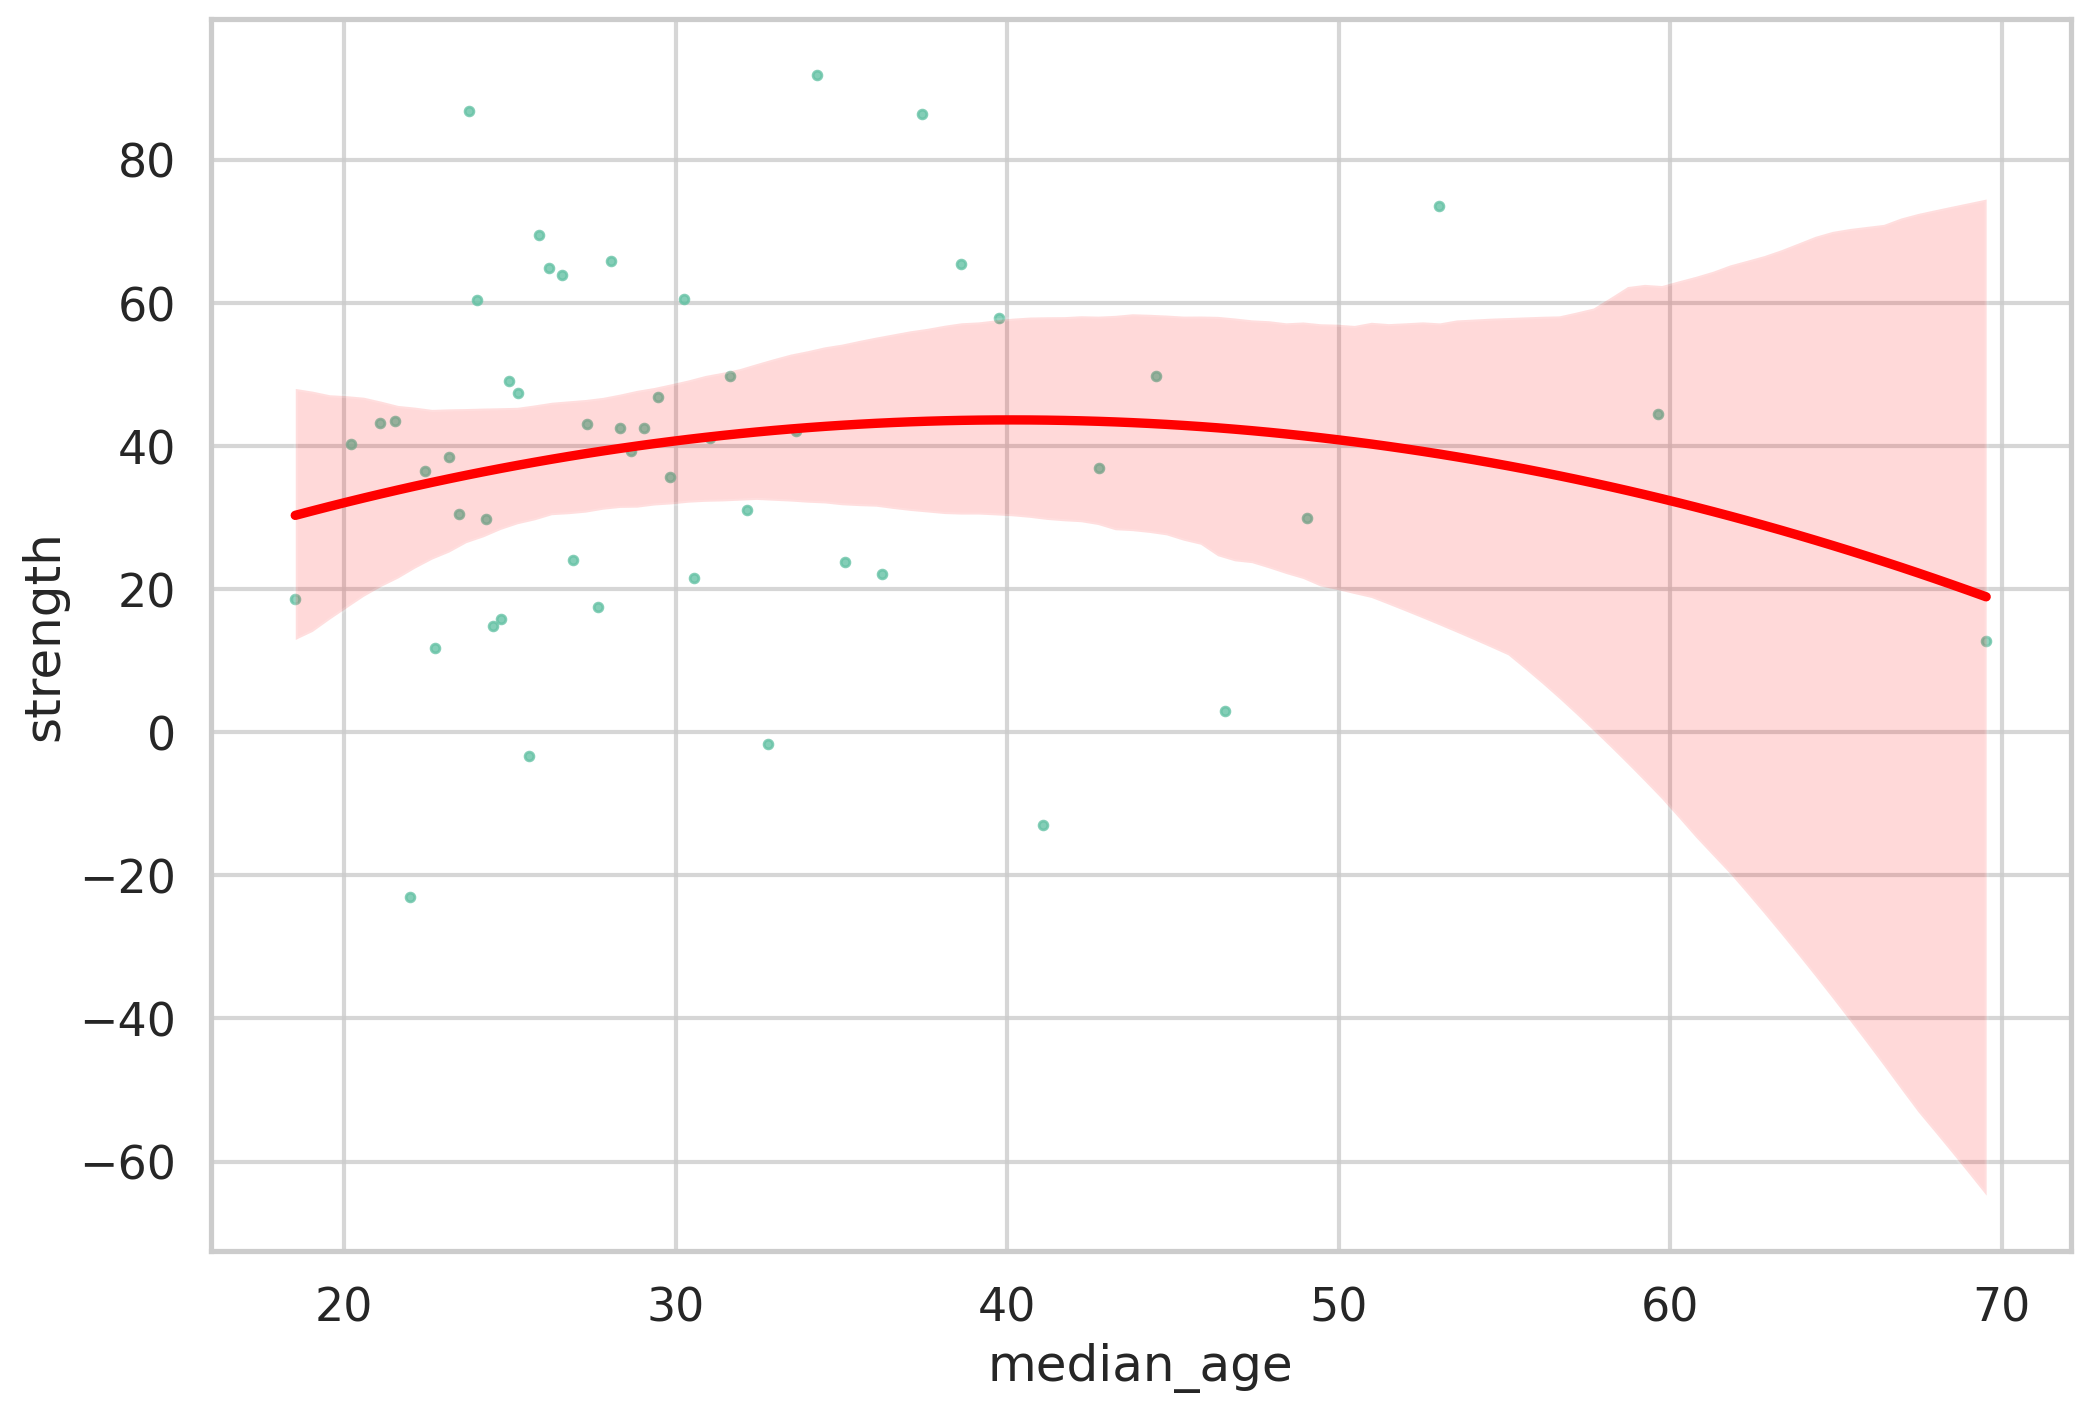

In [115]:
i = vis_df.sort_values("quad_beta2", ascending=True).index[3]
row = vis_df.loc[i]
X_full = network_matrices.loc[network_matrices[region_col] == row[region_col]]
y = X_full[key]
age_vec = X_full["median_age"].astype(float)
X = sm.add_constant(age_vec)
# Fit the OLS model
lin_model = sm.OLS(y, X).fit()
quad_model = sm.OLS(y, sm.add_constant(np.column_stack((age_vec, age_vec**2)))).fit()
# Store the results

sns.regplot(x=age_vec, y=y, scatter_kws={"s": 10}, line_kws={"color": "red"}, order=2)

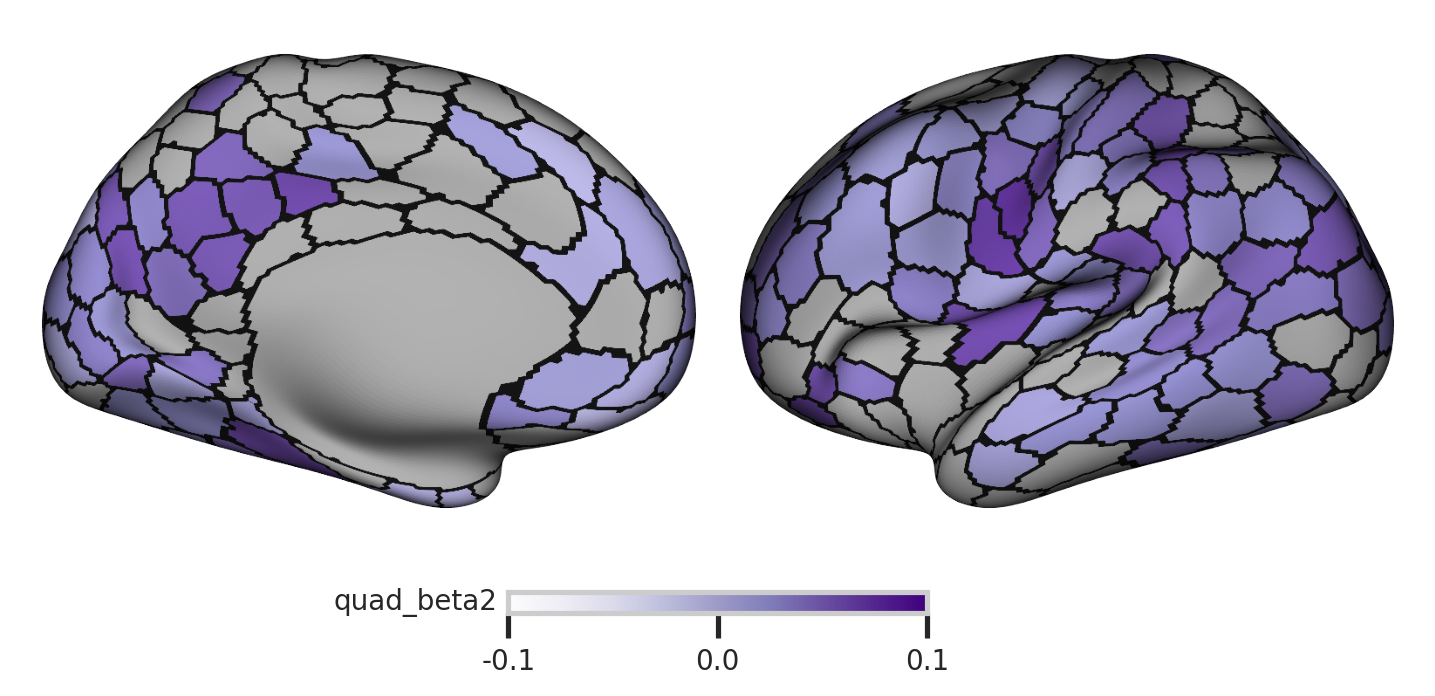

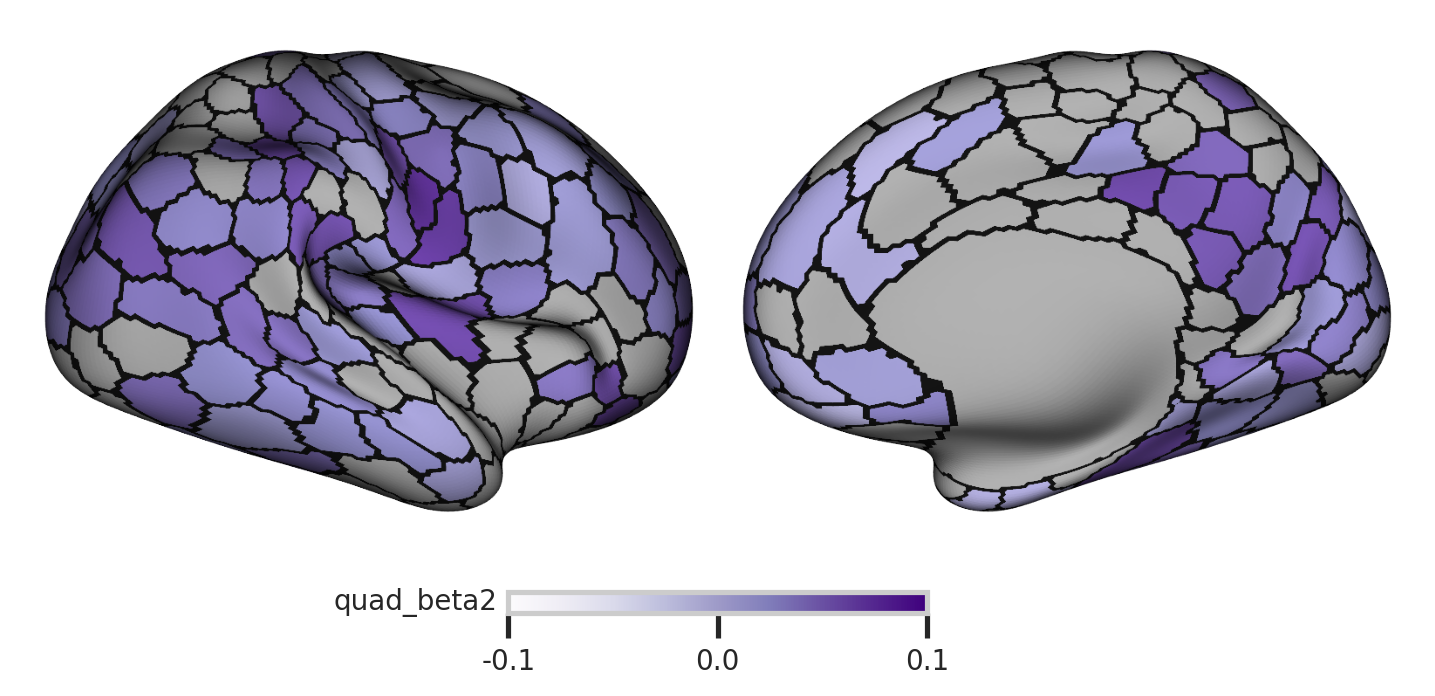

In [ ]:
vmin = 0
vmax = 0.4
# vmin = -0.1
# vmax = 0.1

for hemi, hemi_data, key, vis_data in zip(
    ["L", "R"], [lh, rh], ["left", "right"], [data_lh, data_rh]
):
    # ---------------------------------------------------------------------
    # 5.  BUILD THE PLOT
    # ---------------------------------------------------------------------
    p = Plot(
        hemi_data,
        # rh,
        # views="latmed",  # L-lat, L-med, R-lat, R-med
        size=(800, 300),  # px; change as needed
        zoom=1.6,
        layout="row",
        mirror_views=True,
        views=["medial", "lateral"],
    )

    # ---- main data layer -------------------------------------------------
    # If your metric is centred on 0 (e.g., t-values) use TwoSlopeNorm for symmetry
    # norm = TwoSlopeNorm(
    #     vmin=np.nanmin([data_lh, data_rh]), ,vmax=np.nanmax([data_lh, data_rh])
    # )

    p.add_layer(
        {"left": data_lh, "right": data_rh},
        cmap="Purples",
        color_range=(vmin, vmax),
        # color_range=(2.5,3.5),
        cbar_label=value_column,
    )
    # ---- outline layer ---------------------------------------------------
    # Re-use the label arrays; surfplot draws borders when as_outline=True
    p.add_layer({"left": lh_parc, "right": rh_parc}, cmap="gray", as_outline=True, cbar=False)

    # fig = p.build(cbar_kws=dict(location="bottom", decimals=2))
    fig = p.build()

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_{metric}_{hemi}_{value_column}.png", dpi=400)

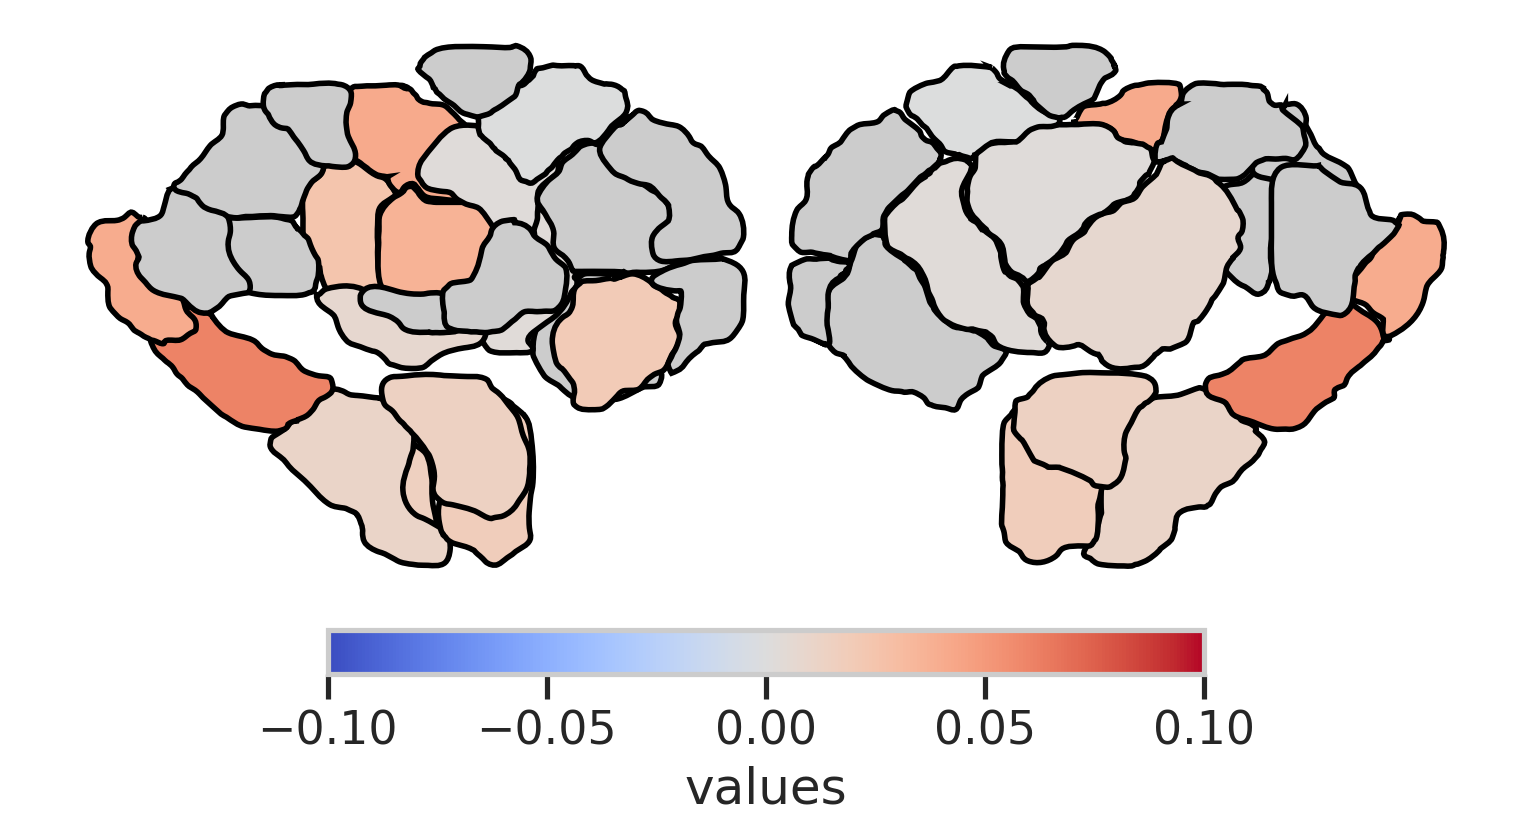

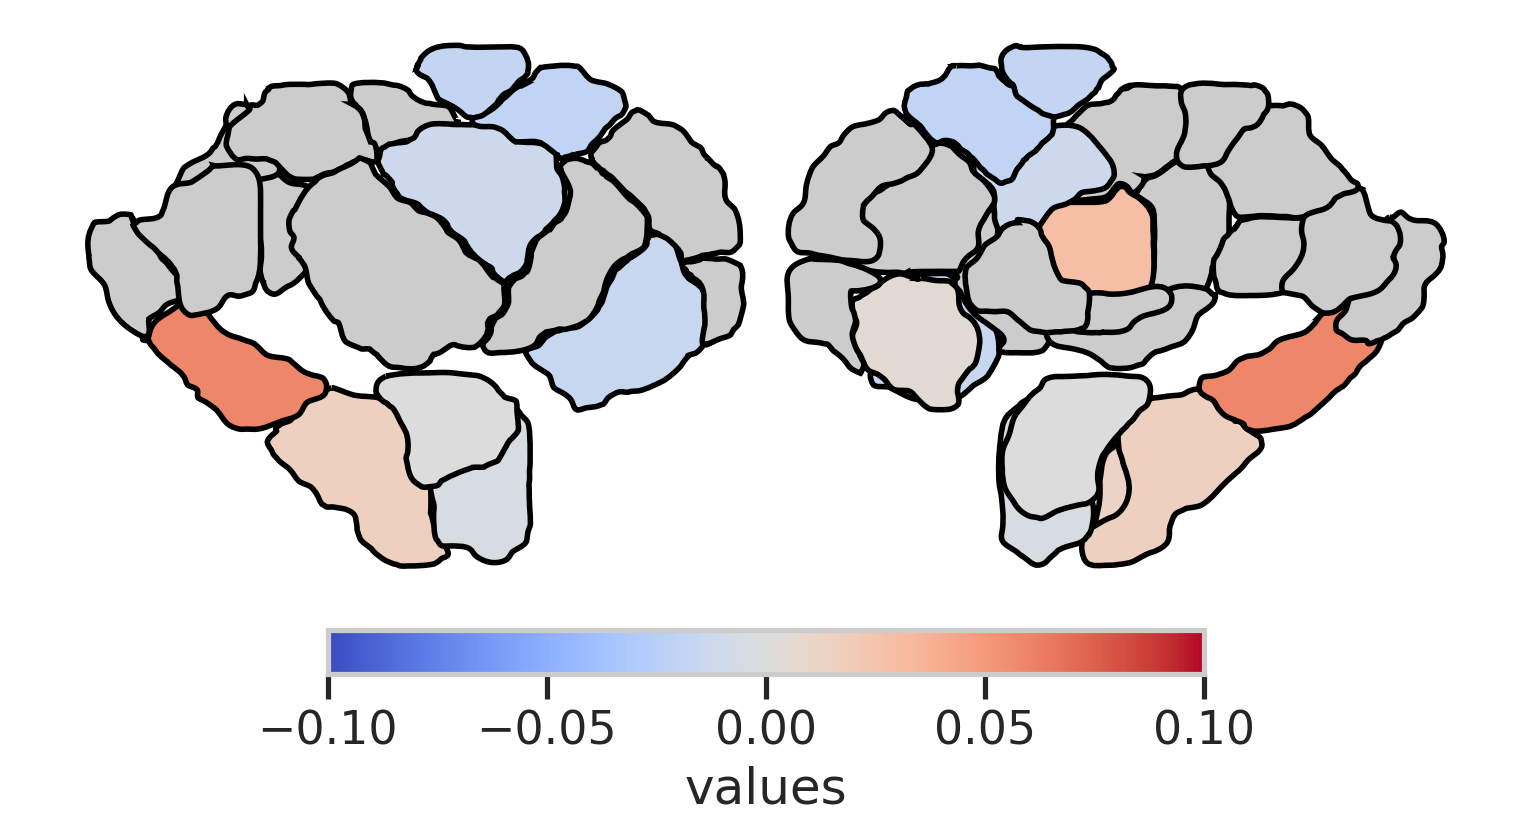

In [ ]:
from subcortex_visualization.plotting import plot_subcortical_data

subcort_df = pd.DataFrame(value_map_subcortex)
if "schaefer" in ATLAS:
    subcort_df["region"] = subcort_df["region"] - int(ATLAS.split("_")[1])


for hemi in ["L", "R"]:

    fig = plot_subcortical_data(
        subcort_df,
        atlas="Melbourne_S3",
        show_legend=True,
        hemisphere=hemi,
        cmap="Purples",
        line_color="black",
        line_thickness=2,
        vmin=vmin,
        vmax=vmax,
        show_figure=False,
    )

    # save figure
    # savefig_nice(fig, OUTPUT_DIR / f"fig2_subcort_{metric}_{hemi}_{value_column}.png", dpi=400)

<Axes: xlabel='median_age', ylabel='global_efficiency'>

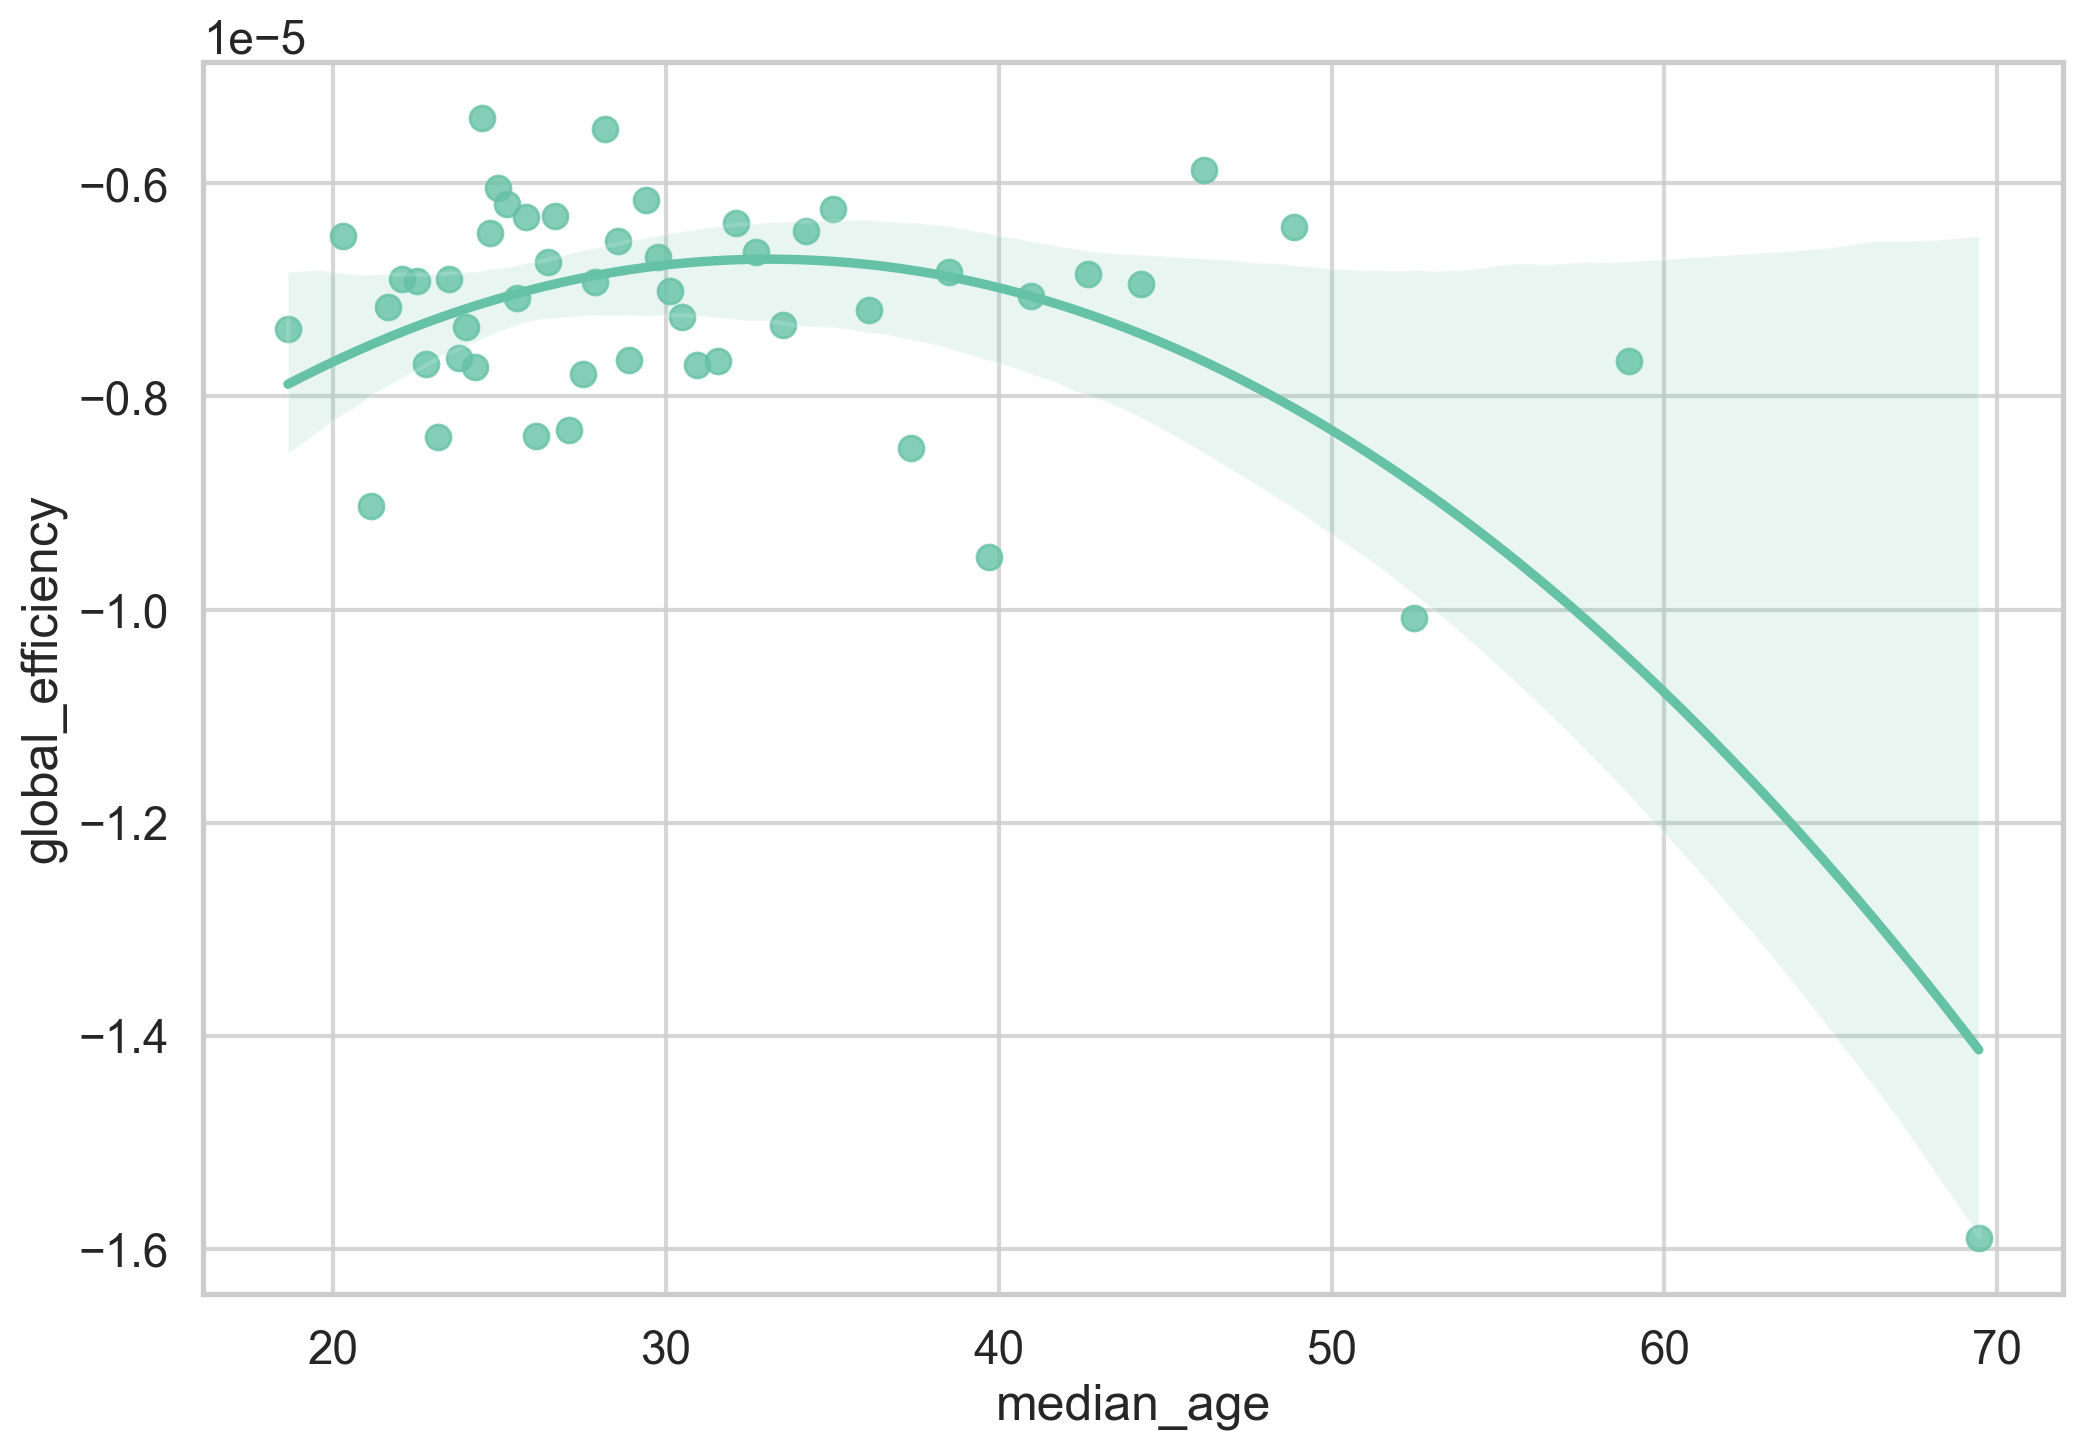

In [59]:
sns.regplot(
    data=network_matrices.drop_duplicates(subset=["group"], keep="first"),
    y="global_efficiency",
    x="median_age",
    order=2
)

<Axes: xlabel='age_group_label', ylabel='age_at_scan'>

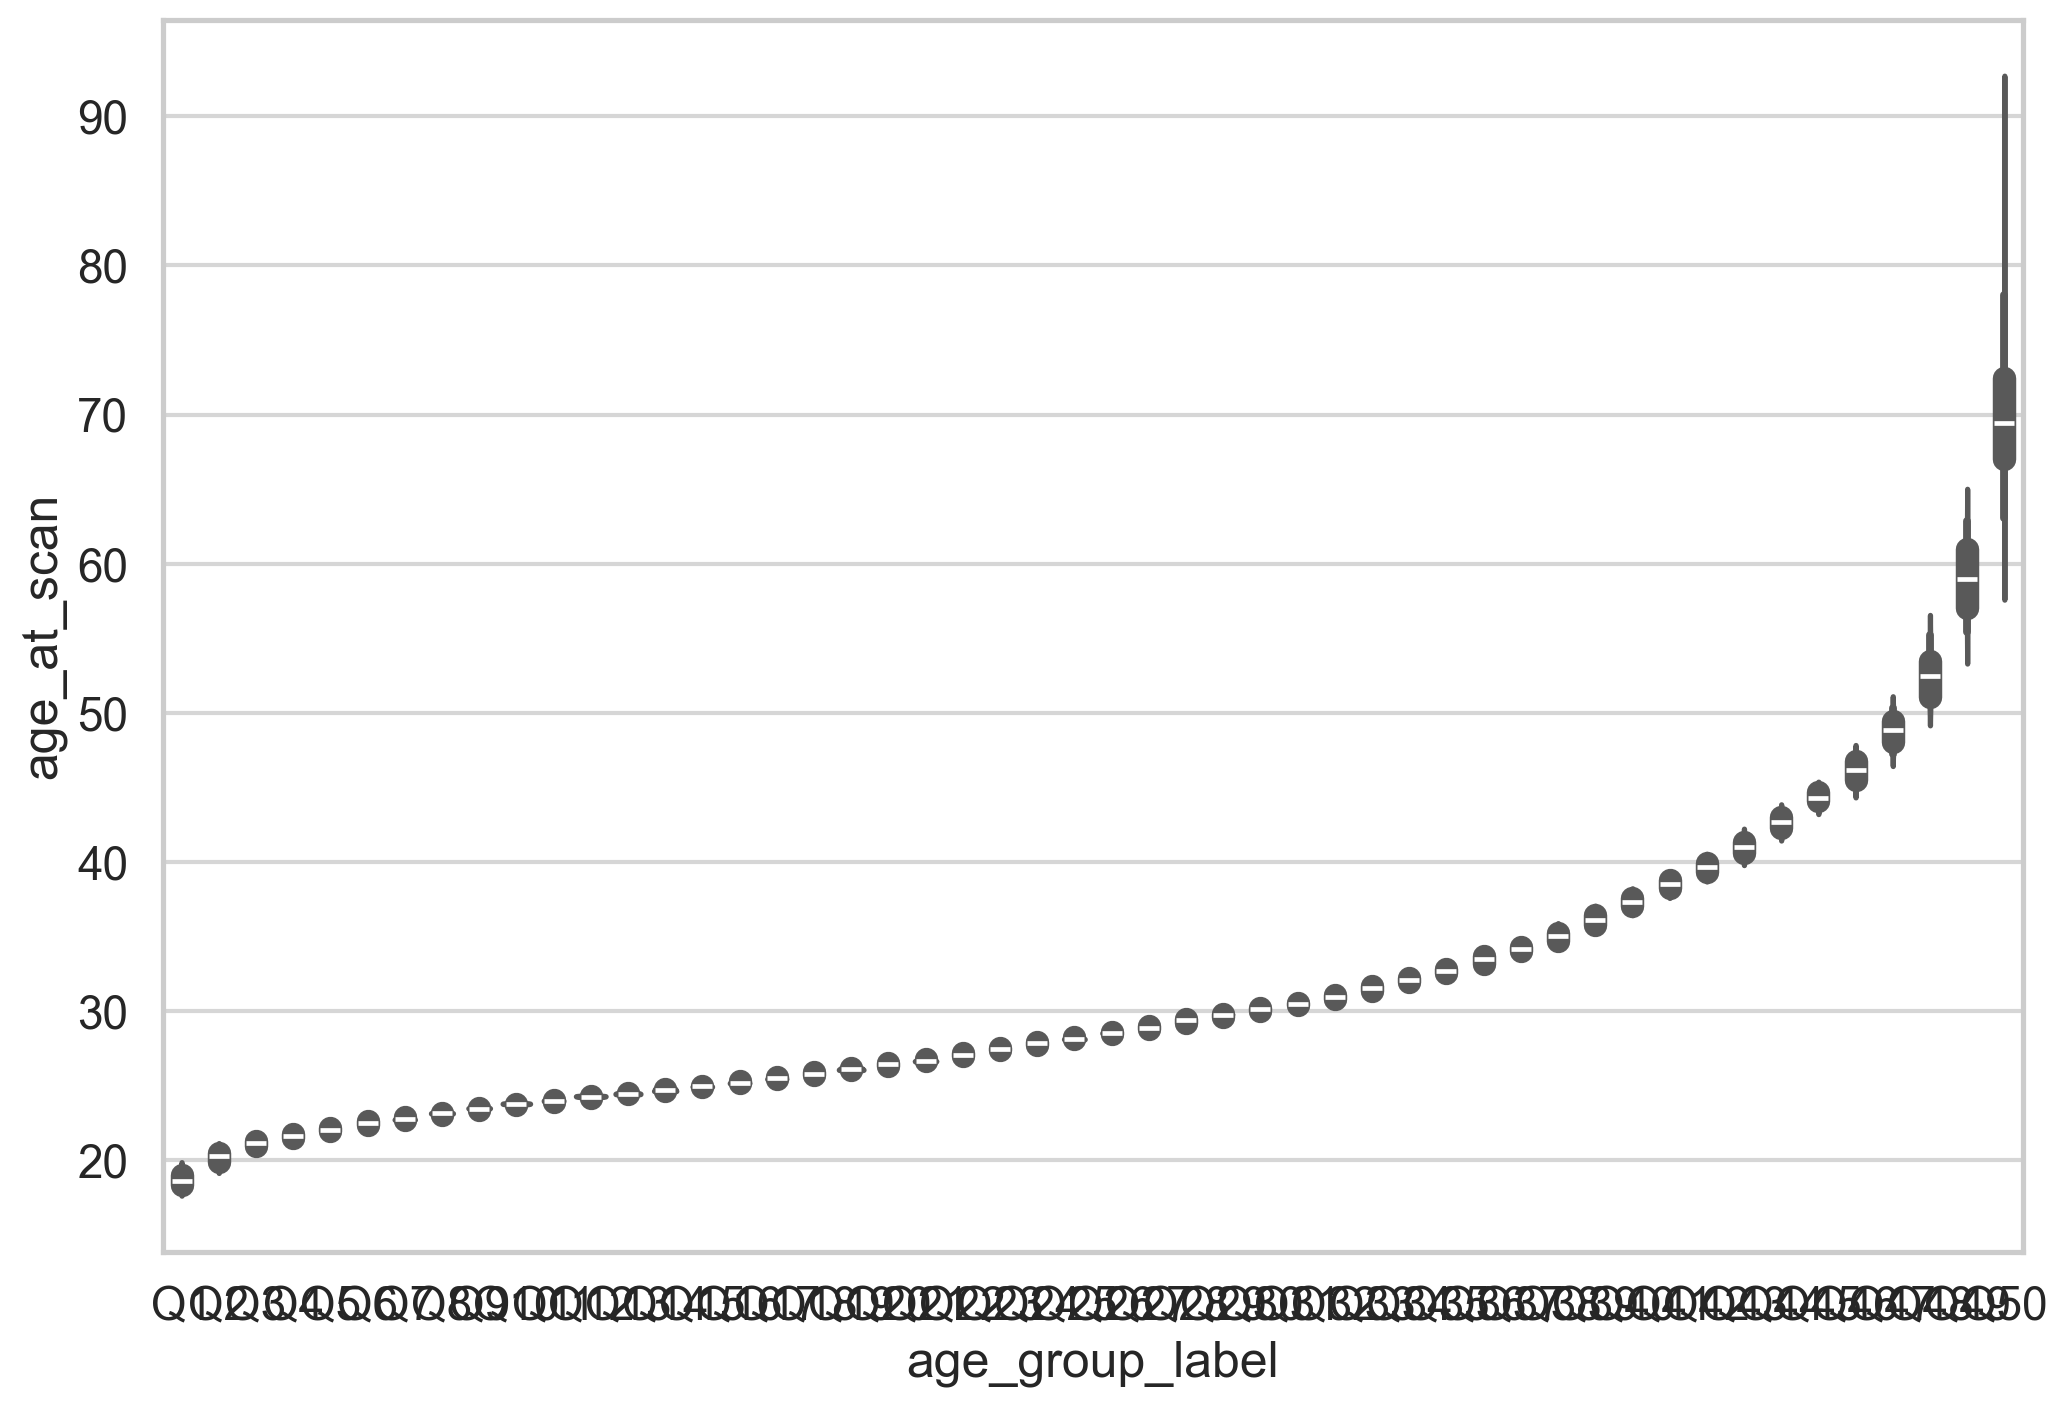

In [41]:
import seaborn as sns

sns.violinplot(
    data=df,
    x="age_group_label",
    y="age_at_scan"
)